# PRÁCTICA 2: MCIB-19P
## Actividad 1

In [1]:
"""Importación de librerías y funciones necesarias"""
import os
import numpy                as np
import matplotlib.pyplot    as plt
from   scipy import fftpack as fft
from   numpy.linalg         import inv
from   scipy.signal         import hann, flattop, blackman, freqz, butter, filtfilt, cheby1

1. Desarrollar una función que calcule la FFT aplicando por lo menos tres ventanas de tal forma que se pueda evaluar cual ventana permite visualizar de mejor manera al espectro

In [2]:
def fft_3w(senal,sr,win = 'han'):
    """Eje de frecuencias para graficar FFT"""
    N = senal.shape[0]
    f = np.linspace(0,sr/2,N//2)
    
    """Cálculo de FFTs con ventanas y sin ventana"""
    #Ventana Hanning
    if win == 'han':
        W_h = hann(N)
        Fwh = fft.fft(senal*W_h)
        Fwh = 20*np.log10(np.abs(Fwh))
        return Fwh[:N//2], f
    #Ventana Flattop
    elif win == 'fla':
        W_f = flattop(N)
        Fwf = fft.fft(senal*W_f)
        Fwf = 20*np.log10(np.abs(Fwf))
        return Fwf[:N//2], f
    #Ventana Blackman
    elif win == 'bla':
        W_b = blackman(N)
        Fwb = fft.fft(senal*W_b)
        Fwb = 20*np.log10(np.abs(Fwb))
        return Fwb[:N//2], f
    #FFT sin ventana
    elif win == 'none':
        F = fft.fft(senal)
        F = 20*np.log10(np.abs(F))
        return F[:N//2], f
    #Todas las opciones de FFT
    elif win == 'all':
        F = fft.fft(senal)
        F = 20*np.log10(np.abs(F))
        W_h = hann(N)
        Fwh = fft.fft(senal*W_h)
        Fwh = 20*np.log10(np.abs(Fwh))
        W_f = flattop(N)
        Fwf = fft.fft(senal*W_f)
        Fwf = 20*np.log10(np.abs(Fwf))
        W_b = blackman(N)
        Fwb = fft.fft(senal*W_b)
        Fwb = 20*np.log10(np.abs(Fwb))
        return F[:N//2], Fwh[:N//2], Fwf[:N//2], Fwb[:N//2], f
    #Mensaje de error para selección invalida
    else:
        print('Ha seleccionado una ventana invalida')
        return []

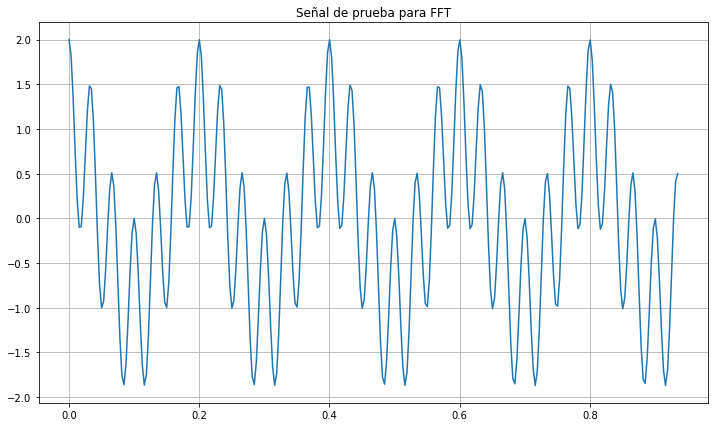

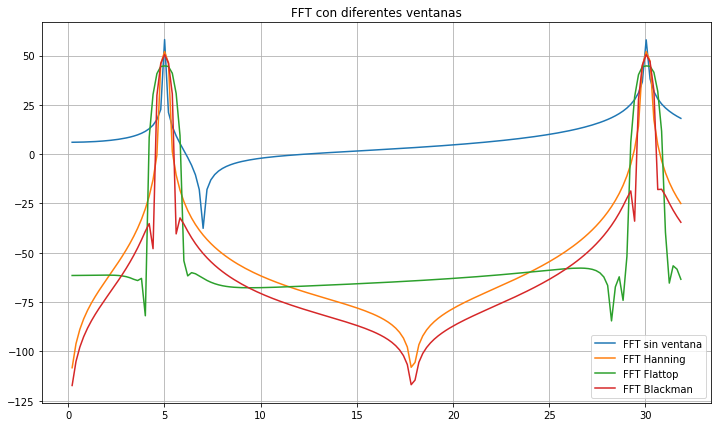

In [3]:
"""Señal de prueba FFT"""

"""Declaración de constantes"""
sr = 320 #Frecuencia de muestreo
L  = 5   #Duración de la señal en segundos
F  = []  #Lista donde se almacenarán las frecuencias de las señales
F.append(5)
F.append(30)
N = L*sr

"""Declaración de eje de tiempo y adecuación de lista de arreglos"""
t = np.linspace(0,L,L*sr)[:,np.newaxis] #Eje de tiempo
F = np.array(F)[np.newaxis] #Conversión de lista a array

"""Creación de señal total mediante una suma de ensamble"""
n = (2*np.pi*t*F) #Muestras de tiempo para cada frecuencia
s = np.cos(n) #Matriz con señales senoidales
s = s.sum(axis=1) #Suma de senoidales para obtener una sola señal

"""Gráficas de señales resultante"""
plt.figure(figsize=(12,7))
plt.title('Señal de prueba para FFT')
plt.plot(t[:300],s[:300])
plt.grid(True)
plt.show()

"""Comprobación de funcionalidad de función fft_3w"""
F, Fwh, Fwf, Fwb, f = fft_3w(s,sr,'all')

"""Gráficas de las FFT"""
plt.figure(figsize=(12,7))
plt.plot(f[1:N//10],F[1:N//10]) #FFT sin aplicar ventana
plt.plot(f[1:N//10],Fwh[1:N//10]) #FFT con ventana Hanning
plt.plot(f[1:N//10],Fwf[1:N//10]) #FFT con ventana Flattop
plt.plot(f[1:N//10],Fwb[1:N//10]) #FFT con ventana Kaiser
plt.grid(True)
plt.legend(['FFT sin ventana', 'FFT Hanning', 'FFT Flattop', 'FFT Blackman'])
plt.title('FFT con diferentes ventanas')
plt.show()

2. Desarrollar una función que estime el PSD con el algoritmo de Welch, siendo sus entradas: señal, longitud de las épocas (N), y porcentaje de traslape (p)

In [4]:
def psd_welch(s,N,p,sr):
    """Conversión de señal de array a lista"""
    s_l = s.tolist()
    eps =[] #Lista para almacenar épocas
    
    """Indices para recorrer épocas"""
    idxs = np.arange(N-1,s.shape[0],N*(1-p))
    idxi = np.arange(0,s.shape[0]+1-N,N*(1-p))
    
    for i,j in zip(idxi,idxs):
        eps.append(s_l[int(i):int(j)+1])
    
    """Conversión de lista a array"""
    eps = np.array(eps)
    eps = eps.transpose()
    
    """Estimación de FFT para cada época"""
    suma = eps.sum(axis = 1)
    Ft = fft.fft(suma)
    F = 20*np.log10(np.abs(Ft))
    F = F/eps.shape[1]
    
    """Eje de frecuencias para graficar PSD"""
    f = np.linspace(0,sr/2,F.shape[0]//2)
    
    return F[:F.shape[0]//2], f

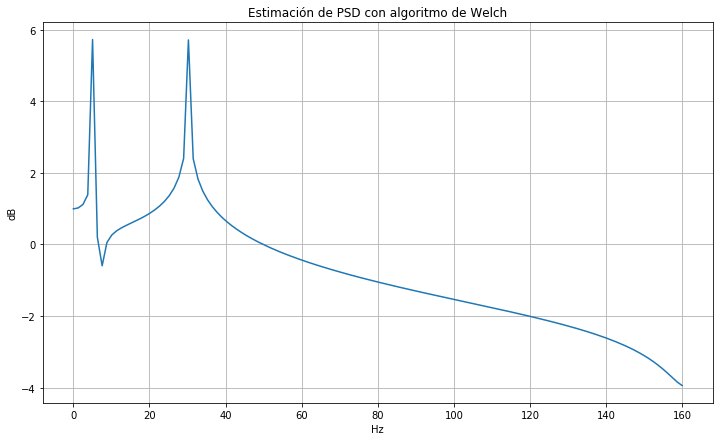

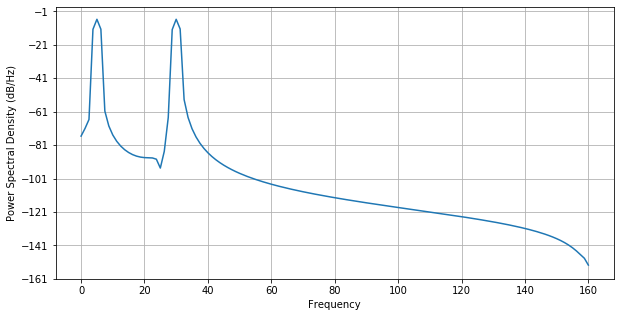

In [5]:
"""Comprobación de funcionalidad de función psd_welch"""
F,f = psd_welch(s,256,0.5,sr)

"""Gráfica resultante"""
plt.figure(figsize=(12,7))
plt.title('Estimación de PSD con algoritmo de Welch')
plt.plot(f,F)
plt.grid(True)
plt.xlabel('Hz')
plt.ylabel('dB')
plt.show()

plt.figure(figsize=(10,5))
plt.psd(s,Fs=sr,NFFT=256)

plt.show()

3. Desarrollar una función que permita evaluar la respuesta en frecuencia de un filtro digital

In [6]:
def Hz(b,a,sr):
    
    """Caracterización de filtro digital"""
    w, h = freqz(b,a)
    h[h==0] = 1E-5 #Caso especial de valore cero para evitar error en logaritmo
    H    = 20*np.log10(np.abs(h)) #Conversión a dB de magnitud de Hz
    W    = np.angle(h,deg = True) #Obtención de fase fe Hz
    w    = np.linspace(0,sr/2,H.shape[0]) #Eje de frecuencias
    
    return w, W, H

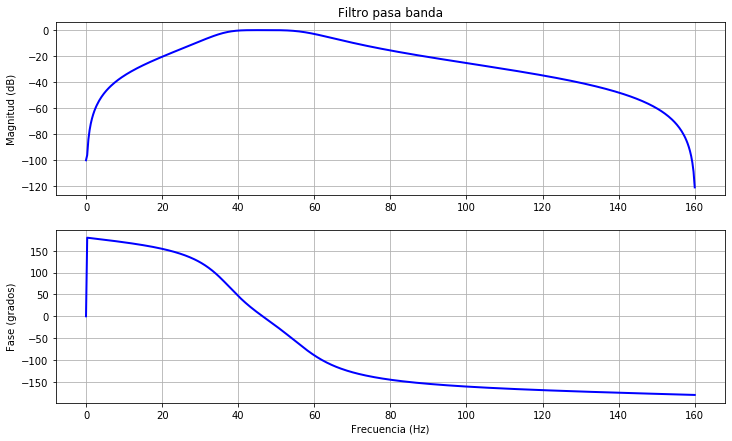

In [7]:
"""Filtro digital de prueba"""

"""Declaración de constantes"""
sr  = 320
n   = 2
fc  = 2*np.array( [35,60] )/float(sr)
b,a = butter(n, fc, btype='band')

"""Comprobación de funcionalidad de función Hz"""
w, W, H = Hz(b,a,sr)

"""Gráficas de respuesta en frecuencia"""
#Magnitud
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.plot(w,H,'blue',linewidth=2)
plt.title("Filtro pasa banda")
plt.ylabel("Magnitud (dB)")
plt.grid(True)
#Fase
plt.subplot(2,1,2)
plt.plot(w,W,'blue',linewidth=2)
plt.ylabel("Fase (grados)")
plt.xlabel("Frecuencia (Hz)")
plt.grid(True)
plt.show()

4. Implementar una función que evalúe un filtro de media móvil, para épocas de N muestras con p porcentaje de traslape

In [8]:
def mean_mov(s,N):

    s_f = [] #Lista para almacenar resultado de media móvil
    L   = s.shape[0] #Obtención de tamaño de señal
    
    #Ciclo para realizar media móvil
    for i in range(0,L):
        #Caso especial para posición de muestras menor a N
        if i < N-1:
            t = s[i] - s[:i+1].sum()/N
            s_f.append(t)
        else:
            t = s[i] - s[i-N+1:i+1].mean()
            s_f.append(t)
        
    return np.array(s_f)

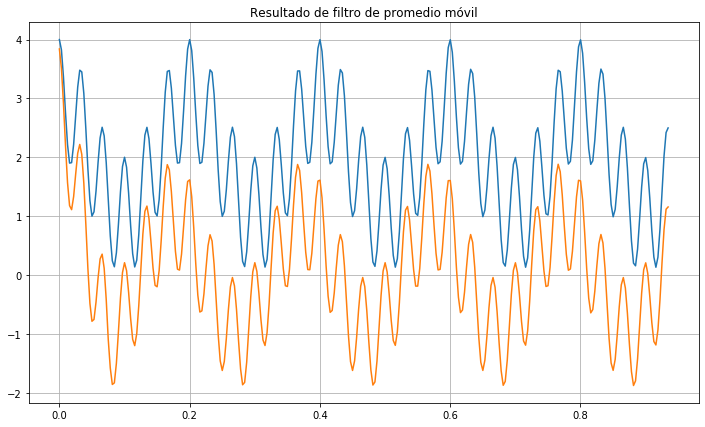

In [9]:
"""Señal de prueba para media móvil"""
s2 = s + 2 #Misma señal que para FFT y PSD sólo que con offset


"""Comprobación de funcionalidad de pro_mov con 25 muestras"""
s_f = mean_mov(s2,25)

"""Gráfica de señal resultante"""
plt.figure(figsize=(12,7))
plt.title('Resultado de filtro de promedio móvil')
plt.plot(t[:300],s2[:300])
plt.plot(t[:300],s_f[:300])
plt.grid(True)
plt.show()

5. Implementar una función que elimine la tendencia lineal móvil, asumiendo un 50% de traslape de épocas de N muestras, y utilizando el método de la pseudo-inversa

In [10]:
def detrend (s,N,time):
    #p = 0.5
    """Conversión de señal de array a lista"""
    s_l = s.tolist()
    eps =[] #Lista para almacenar épocas
    ts  =[] # Lista para la época de timepo
    lis =[]
    
    """Indices para recorrer épocas"""
    idxs = np.arange(N-1,s.shape[0]+1,N)
    idxi = np.arange(0,s.shape[0]+1-N,N)
    
    for i,j in zip(idxi,idxs):
        eps.append(s_l[int(i):int(j)+1])
        ts.append(time[int(i):int(j)+1])
                
    """Conversión de lista a array"""
    eps = np.array(eps)
    eps = eps.transpose()
    ts = np.array(ts)
    ts = ts.transpose()
    
    for i in range (idxs.shape[0]):
        X = ts[:,i]
        X = X[:,np.newaxis]
        Y = eps[:,i]
        Y = Y[:,np.newaxis]
        X = np.append(X,np.ones((N))).reshape(N,2)
        Xt = X.transpose()
        W = inv(np.dot(Xt,X))
        W = np.dot(W,Xt)
        W = np.dot(W,Y)
        rec = np.dot(X,W)
        lis = np.append(lis,Y-rec)
        #print(lis.shape)
    return lis

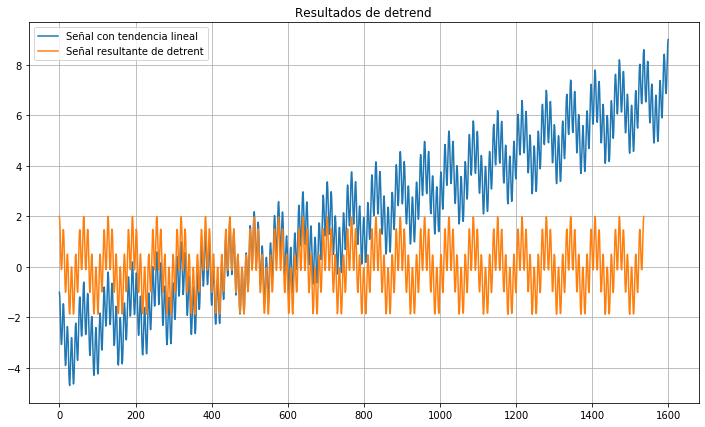

In [11]:
"""Señal de prueba para tendencia lineal"""

#Parámetros de la recta
m = 2
b = -3
recta = (t*m)+b #Recta para diseñar tendencia lineal
S_rect = s+recta[:,0] #Señal a utilizar para retirar tendencia lineal

"""Comprobaciónn de funcionalidad de función detrent"""
s_det = detrend(s,256,t[:,0].tolist())

"""Gráfica comparativa de resultados"""
plt.figure(figsize=(12,7))
plt.plot(S_rect)
plt.plot(s_det)
plt.grid(True)
plt.title('Resultados de detrend')
plt.legend(['Señal con tendencia lineal','Señal resultante de detrent'])
plt.show()

## Actividad 2
1.Estimar el espectro para cada una de las señales adquiridas en la Práctica 0. ¿Los espectros de un mismo tipo de señal son parecidos a pesar de haber sido adquiridos en diferentes sesiones?

## NO es diagonal invertida en los path relativos

In [14]:
"""Configuración del path de datos"""
directorio = os.path.abspath('../../data')
print(directorio)

/home/omarpr/git/MCIB-19-P/eval/KA/data


In [16]:
"""Apertura de archivos adquiridos en Práctica 0"""
#Lista con nombre de los archivos a cargar
archivos = ['A1','A2','A2_1','A2_2','A2_3','A2_4','A2_5','A2_6','A3_1','A3_2','A3_3','A3_4','A3_5']

#Ciclo que permite abrir los archivos y almacenarlos en una variable cuyo nombre sea el mismo que el archivo
for i in archivos:
    temp = np.loadtxt(directorio+'/'+i+'.csv',delimiter=',',dtype = 'str') #Se carga el archivo
    exec('%s = temp[4:,:5].astype(''float'')'%i) #Recortw para eliminar los encabezados y las columnas innecesarias
    head = temp[0:2,:5] #Variable que recupera los encabezados y las unidades de las señales
    
#Eje de tiempo para los registros
sr    = 1000
time1 = np.linspace(0,A1.shape[0]/sr,A1.shape[0])
time2 = np.linspace(0,A2_1.shape[0]/sr,A2_1.shape[0])
time3 = np.linspace(0,A3_1.shape[0]/sr,A3_1.shape[0])

In [14]:
head

array([['OXY', 'EMG', 'ECG', 'RSP', 'OXY'],
       ['PO2', 'mV', 'mV', 'V', 'Pulse']], dtype='<U12')

In [17]:
"""Debido a que existen varios registros solamente se tomará uno de cada actividad para resolver lo solicitado"""
#Registros de EMG
F_EMG_A1,  f1 = fft_3w(A1[:,1]  ,sr,'han')
F_EMG_A21, f2 = fft_3w(A2_1[:,1],sr,'han')
F_EMG_A31, f3 = fft_3w(A3_1[:,1],sr,'han')

#Registros de EKG
F_EKG_A1,  f1 = fft_3w(A1[:,2]  ,sr,'han')
F_EKG_A21, f2 = fft_3w(A2_1[:,2],sr,'han')
F_EKG_A31, f3 = fft_3w(A3_1[:,2],sr,'han')

#Registros de respiración
F_RSP_A1,  f1 = fft_3w(A1[:,3]  ,sr,'han')
F_RSP_A21, f2 = fft_3w(A2_1[:,3],sr,'han')
F_RSP_A31, f3 = fft_3w(A3_1[:,3],sr,'han')

#Registros de onda de pulso
F_PUL_A1,  f1 = fft_3w(A1[:,4]  ,sr,'none')
F_PUL_A21, f2 = fft_3w(A2_1[:,4],sr,'none')
F_PUL_A31, f3 = fft_3w(A3_1[:,4],sr,'none')

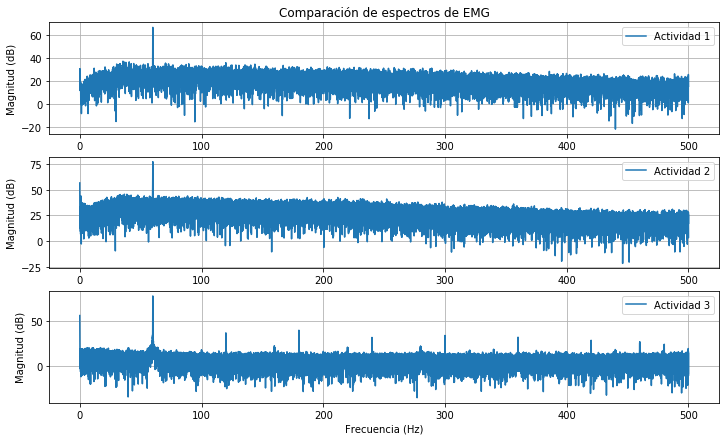

In [18]:
"""Comparación de los espectros de cada señal"""
#Espectros de EMG
plt.figure(figsize = (12,7))
plt.subplot(3,1,1)
plt.plot(f1,F_EMG_A1)
plt.title('Comparación de espectros de EMG')
plt.legend(['Actividad 1'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(f2,F_EMG_A21)
plt.legend(['Actividad 2'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(f3,F_EMG_A31)
plt.legend(['Actividad 3'])
plt.ylabel('Magnitud (dB)')
plt.xlabel('Frecuencia (Hz)')
plt.grid(True)
plt.show()

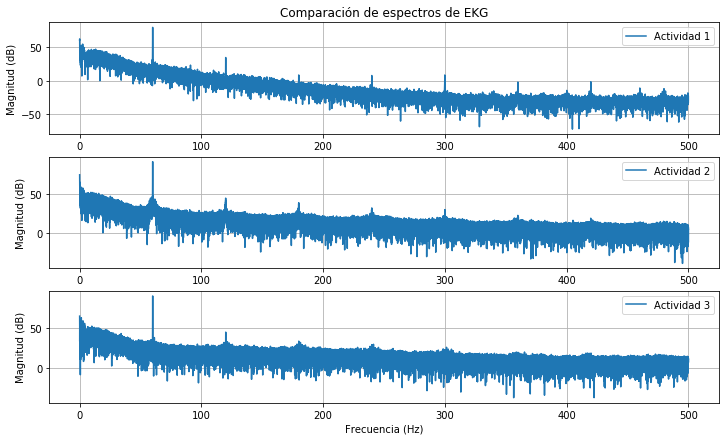

In [19]:
#Espectros de EKG
plt.figure(figsize = (12,7))
plt.subplot(3,1,1)
plt.plot(f1,F_EKG_A1)
plt.title('Comparación de espectros de EKG')
plt.legend(['Actividad 1'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(f2,F_EKG_A21)
plt.legend(['Actividad 2'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(f3,F_EKG_A31)
plt.legend(['Actividad 3'])
plt.ylabel('Magnitud (dB)')
plt.xlabel('Frecuencia (Hz)')
plt.grid(True)
plt.show()

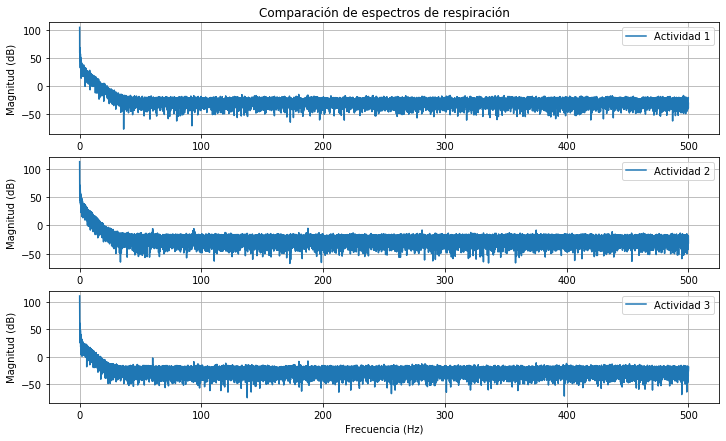

In [23]:
#Espectros de respiración
plt.figure(figsize = (12,7))
plt.subplot(3,1,1)
plt.plot(f1,F_RSP_A1)
plt.title('Comparación de espectros de respiración')
plt.legend(['Actividad 1'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(f2,F_RSP_A21)
plt.legend(['Actividad 2'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(f3,F_RSP_A31)
plt.legend(['Actividad 3'])
plt.ylabel('Magnitud (dB)')
plt.xlabel('Frecuencia (Hz)')
plt.grid(True)
plt.show()

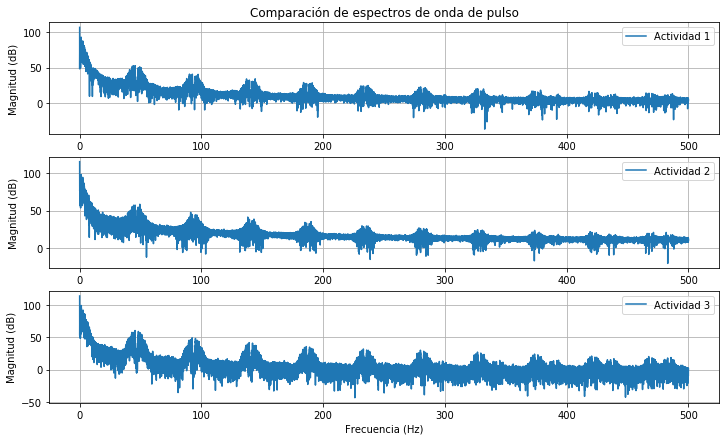

In [19]:
#Espectros de onda de pulso
plt.figure(figsize = (12,7))
plt.subplot(3,1,1)
plt.plot(f1,F_PUL_A1)
plt.title('Comparación de espectros de onda de pulso')
plt.legend(['Actividad 1'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,2)
plt.plot(f2,F_PUL_A21)
plt.legend(['Actividad 2'])
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.subplot(3,1,3)
plt.plot(f3,F_PUL_A31)
plt.legend(['Actividad 3'])
plt.ylabel('Magnitud (dB)')
plt.xlabel('Frecuencia (Hz)')
plt.grid(True)
plt.show()

2. Implementar un esquema de filtrado que mejor se adapte a cada tipo de señal. a) Evaluar la respuesta en frecuencia de los filtros. b) Comparar la señal filtrada respecto a la original

In [25]:
"""Diseño de filtros"""
#Filtro pasa bajas con frecuencia de corte 40 Hz
n1    = 4
fc1   = 2*np.array( [40] )/float(sr)
b1,a1 = butter(n1, fc1, btype='low')

#Filtro pasa banda con frecuencias de corte 10 y 40 Hz
n2    = 5
fc2   = 2*np.array( [10,40] )/float(sr)
b2,a2 = butter(n2, fc2, btype='bandpass')

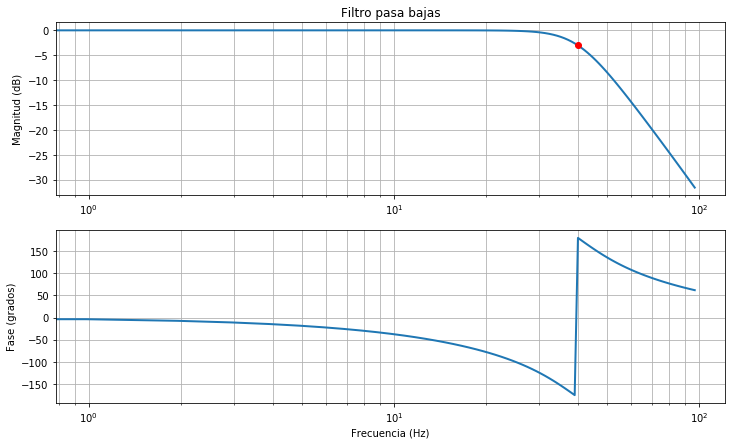

In [26]:
"""Respuesta en frecuencia de los filtros"""
#Filtro pasa bajas
w1, W1, H1 = Hz(b1,a1,sr)
#Magnitud
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.semilogx(w1[:100],H1[:100],linewidth=2)
plt.plot(40,-3,'ro')
plt.title("Filtro pasa bajas")
plt.ylabel("Magnitud (dB)")
plt.grid(which='both')
#Fase
plt.subplot(2,1,2)
plt.semilogx(w1[:100],W1[:100],linewidth=2)
plt.ylabel("Fase (grados)")
plt.xlabel("Frecuencia (Hz)")
plt.grid(which='both')
plt.show()

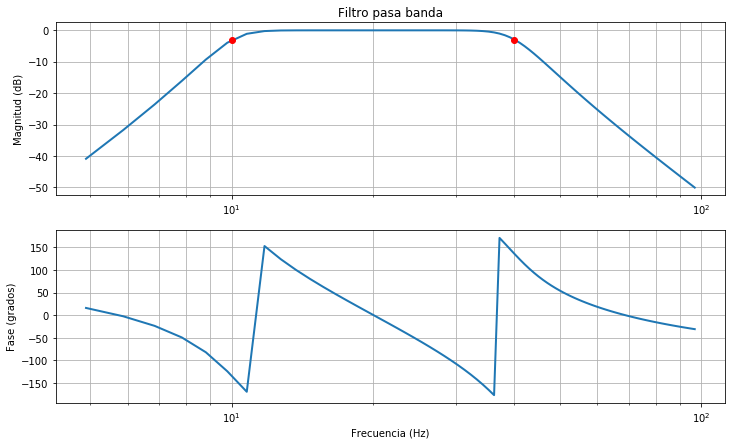

In [27]:
"""Respuesta en frecuencia de los filtros"""
#Filtro pasa banda
w2, W2, H2 = Hz(b2,a2,sr)
#Magnitud
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.semilogx(w2[5:100],H2[5:100],linewidth=2)
plt.plot(10,-3,'ro'),plt.plot(40,-3,'ro')
plt.title("Filtro pasa banda")
plt.ylabel("Magnitud (dB)")
plt.grid(which='both')
#Fase
plt.subplot(2,1,2)
plt.semilogx(w2[5:100],W2[5:100],linewidth=2)
plt.ylabel("Fase (grados)")
plt.xlabel("Frecuencia (Hz)")
plt.grid(which='both')
plt.show()

In [28]:
"""Filtrado de las señales"""
EMG_f_A2_1 = filtfilt(b1,a1,A2_1[:,1])
EKG_f_A2_1 = filtfilt(b2,a2,A2_1[:,2])
RSP_f_A2_1 = filtfilt(b1,a1,A2_1[:,3])

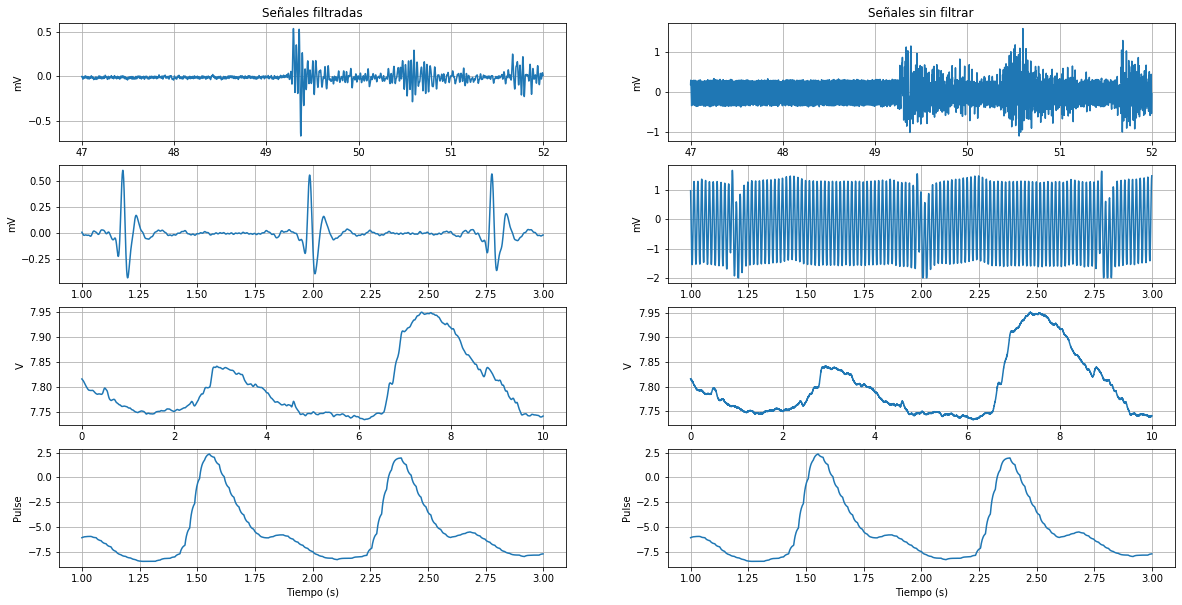

In [29]:
"""Señales resultantes"""
#Señales filtradas
plt.figure(figsize=(20,10))
plt.subplot(4,2,1) #EMG filtrado
plt.plot(time2[47000:52000],EMG_f_A2_1[47000:52000])
plt.title('Señales filtradas')
plt.ylabel('mV')
plt.grid(True)
plt.subplot(4,2,3) #EKG filtrado
plt.plot(time2[1000:3000],EKG_f_A2_1[1000:3000])
plt.ylabel('mV')
plt.grid(True)
plt.subplot(4,2,5) #RSP filtrado
plt.plot(time2[:10000],RSP_f_A2_1[:10000])
plt.ylabel('V')
plt.grid(True)
plt.subplot(4,2,7) #PUL original
plt.plot(time2[1000:3000],A2_1[1000:3000,4])
plt.ylabel('Pulse'),plt.xlabel('Tiempo (s)')
plt.grid(True)

#Señales sin filtrar
plt.subplot(4,2,2) #EMG original
plt.plot(time2[47000:52000],A2_1[47000:52000,1])
plt.title('Señales sin filtrar')
plt.ylabel('mV')
plt.grid(True)
plt.subplot(4,2,4) #EKG original
plt.plot(time2[1000:3000],A2_1[1000:3000,2])
plt.ylabel('mV')
plt.grid(True)
plt.subplot(4,2,6) #RSP original
plt.plot(time2[:10000],A2_1[:10000,3])
plt.ylabel('V')
plt.grid(True)
plt.subplot(4,2,8) #PUL original
plt.plot(time2[1000:3000],A2_1[1000:3000,4])
plt.ylabel('Pulse'),plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.show()

In [30]:
"""Filtrado del resto de registros"""
for i in archivos:
    exec('EMG_f_%s = filtfilt(b1,a1,%s[:,1])'%(i,i))
    exec('EKG_f_%s = filtfilt(b2,a2,%s[:,2])'%(i,i))
    exec('RSP_f_%s = filtfilt(b1,a1,%s[:,3])'%(i,i))

3. Seleccione los registros que requieran que se elimine la tendencia lineal, y elimínela con la función que diseñó. Evalúe que caso preserva más la morfología de la señal: eliminar tendencia -> filtrado vs filtrado -> eliminar tendencia

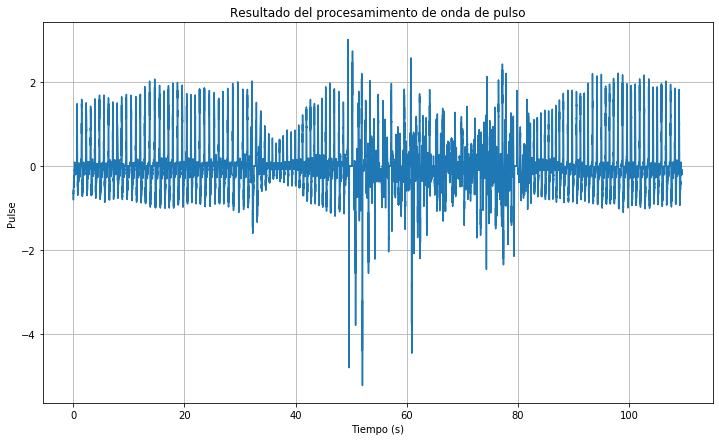

In [32]:
"""Promedio movil para eliminar offset de la onda de pulso"""
PUL_f_A21 = mean_mov(A2_1[:,4],25)

plt.figure(figsize=(12,7))
plt.plot(time2,PUL_f_A21)
plt.title('Resultado del procesamimento de onda de pulso')
plt.ylabel('Pulse'),plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.show()

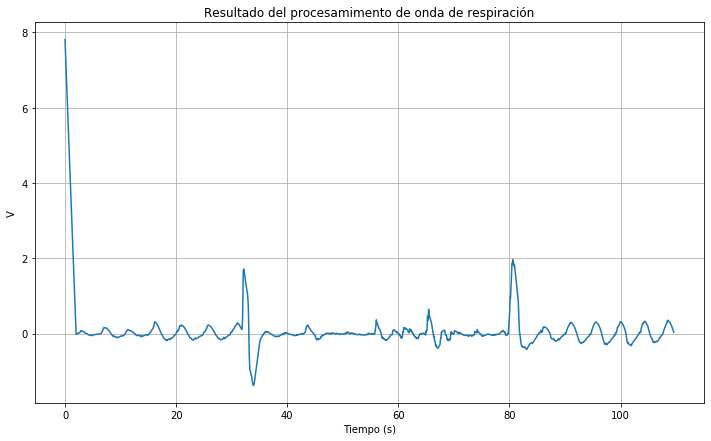

In [33]:
"""Promedio movil para eliminar offset de la onda de respiración"""
RSP_f_A21 = mean_mov(RSP_f_A2_1,2000)

plt.figure(figsize=(12,7))
plt.plot(time2,RSP_f_A21)
plt.title('Resultado del procesamimento de onda de respiración')
plt.ylabel('V'),plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


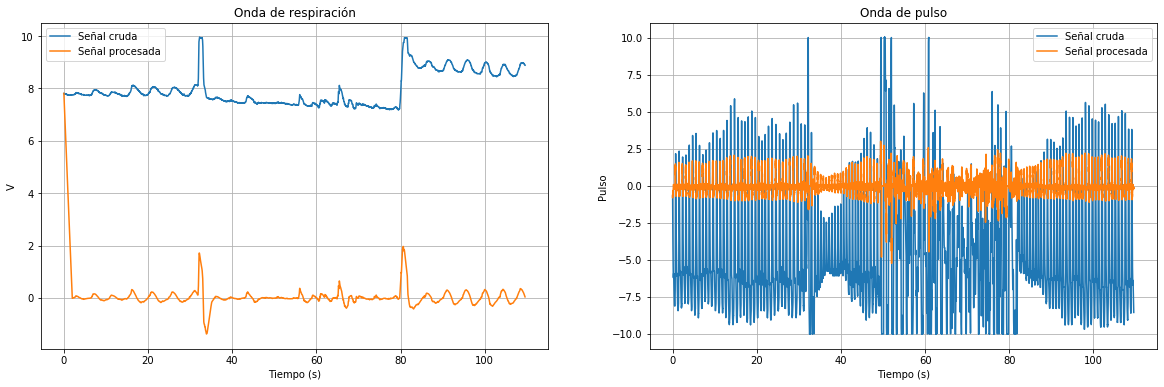

In [34]:
"""Comparacion de las señales"""
plt.figure(figsize = (20,6))
#Onda de respiración
plt.subplot(1,2,1)
plt.plot(time2,A2_1[:,3])
plt.plot(time2,RSP_f_A21)
plt.title('Onda de respiración')
plt.ylabel('V'),plt.xlabel('Tiempo (s)')
plt.legend(['Señal cruda','Señal procesada'])
plt.grid(True)
#Onda de pulso
plt.subplot(1,2,2)
plt.plot(time2,A2_1[:,4])
plt.plot(time2,PUL_f_A21)
plt.title('Onda de pulso')
plt.ylabel('Pulso'),plt.xlabel('Tiempo (s)')
plt.legend(['Señal cruda','Señal procesada'])
plt.grid(True)
plt.show()

In [35]:
"""Procesamiento del resto de registros"""
for i in archivos:
    exec('PUL_f_%s = mean_mov(%s[:,4],25)'%(i,i))
    exec('RSP_f_%s = mean_mov(RSP_f_%s,2000)'%(i,i))

In [30]:
"""Guardado de las señales en formato nativo de numpy"""
for i in archivos:
    path = directorio + '\\'+'%s_f'%i
    eval('np.savez_compressed(path, PO2=%s[:,0], EMG=EMG_f_%s, EKG=EKG_f_%s, RSP=RSP_f_%s, PUL=PUL_f_%s, sr=1000)'%(i,i,i,i,i))